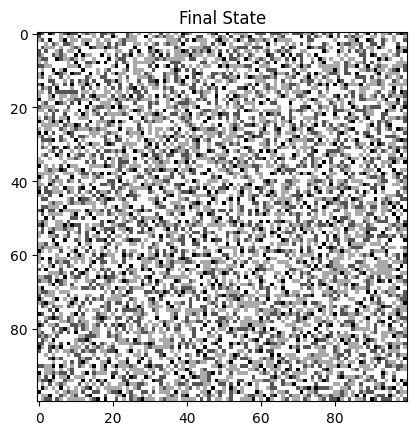

In [8]:
# Pavan SD HW1

import numpy as np
import matplotlib.pyplot as plt

class AbelianSandpile:
    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state)  # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history = [self.grid.copy()]  # To track the history of the grid

    def step(self):
        # Randomly add a grain
        x, y = np.random.randint(0, self.n, 2)
        self.grid[x, y] += 1
        
        # Check for toppling and redistribute grains
        unstable = np.argwhere(self.grid >= 4)
        while len(unstable) > 0:
            for (i, j) in unstable:
                self.grid[i, j] -= 4
                if i > 0: self.grid[i-1, j] += 1
                if i < self.n - 1: self.grid[i+1, j] += 1
                if j > 0: self.grid[i, j-1] += 1
                if j < self.n - 1: self.grid[i, j+1] += 1
            unstable = np.argwhere(self.grid >= 4)
        
        self.history.append(self.grid.copy())

    def simulate(self, n_steps):
        for _ in range(n_steps):
            self.step()

# Initialize model and simulate
model = AbelianSandpile(n=100, random_state=42)
model.simulate(10000)

# Plot the final state
plt.imshow(model.grid, cmap='gray')
plt.title('Final State')
plt.show()


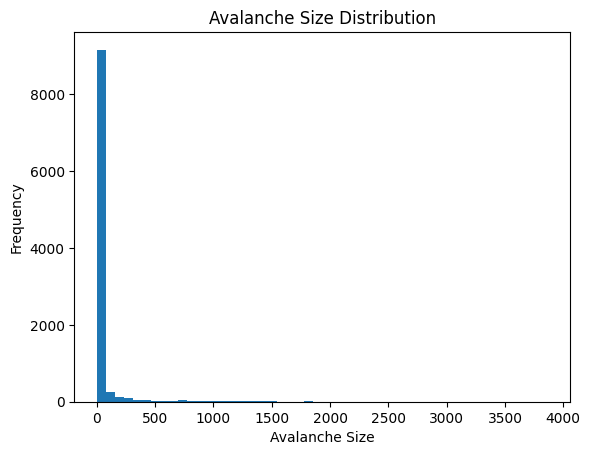

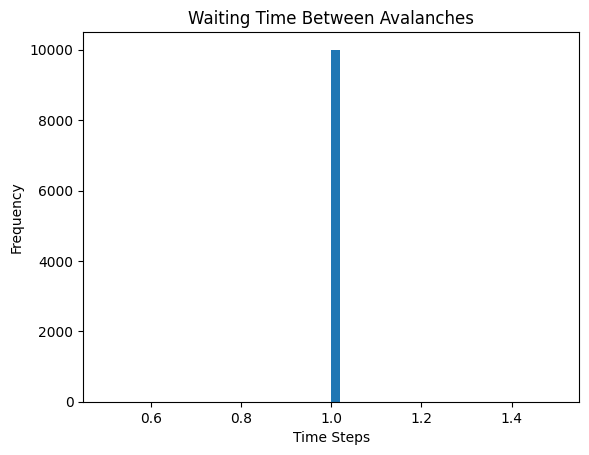

In [9]:
# Compute the pairwise difference between all observed snapshots to detect avalanches
all_events = [model.history[i] != model.history[i-1] for i in range(1, len(model.history))]
# Count how many cells changed state in each event
all_avalanche_sizes = [np.sum(event) for event in all_events]

# Plot the avalanche size distribution
plt.figure()
plt.hist(all_avalanche_sizes, bins=50)
plt.title('Avalanche Size Distribution')
plt.xlabel('Avalanche Size')
plt.ylabel('Frequency')
plt.show()

# Compute the waiting time between avalanches
all_avalanches = [i for i, size in enumerate(all_avalanche_sizes) if size > 0]
waiting_times = np.diff(all_avalanches)

# Plot the waiting time distribution
plt.figure()
plt.hist(waiting_times, bins=50)
plt.title('Waiting Time Between Avalanches')
plt.xlabel('Time Steps')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Analysis
'''
If a single image of the sandpile has size  N  (the total number of lattice sites), 
what do you expect to be the worst-case scaling of the runtime of your algorithm? 
What about the expected scaling of memory usage?
Given that the algorithm iterates over the entire grid and checks each site 
potentially multiple times (once per site that needs redistribution), the 
worst-case runtime complexity is likely O(n^2 x M), where n^2 is the number 
of cells (N in the question) and M is the maximum number of topplings 
required before reaching a stable state. This can become significant, especially 
for large grids or highly unstable initial configurations.
Memory usage should scale linearly with the number of sites, O(n^2) or O(N), as 
each site requires a fixed amount of memory to store its state. Additional memory 
is required for history tracking if implemented, but this does not change the 
overall scaling behavior.


'''

In [32]:
# Class for Percolation Simulation
class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem.
    Given a 2D lattice, blocked sites are denoted by 0s, and open sites by 1s.
    Water fills a site if it reaches an open site directly above, or to the left/right of an open site.
    """
    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        self.random_state = random_state
        np.random.seed(self.random_state)
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)
        
        # Initialize the filled grid
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        """Sample a random lattice for the percolation simulation."""
        self.grid = np.random.choice([0, 1], size=(self.n, self.n), p=[self.p, 1 - self.p])
        self.grid_filled = np.copy(self.grid)
    
    def _poll_neighbors(self, i, j):
        """Check if there is a filled site adjacent to a site at (i, j)."""
        if i > 0 and self.grid_filled[i - 1, j] == 2:
            return True
        if j > 0 and self.grid_filled[i, j - 1] == 2:
            return True
        if j < self.n - 1 and self.grid_filled[i, j + 1] == 2:
            return True
        return False

    def percolate(self):
        """Run a percolation simulation and check if water reaches the bottom."""
        for j in range(self.n):
            if self.grid[0, j] == 1:
                self.grid_filled[0, j] = 2  # Fill top row with water
        
        for i in range(1, self.n):
            for j in range(self.n):
                if self.grid[i, j] == 1 and self._poll_neighbors(i, j):
                    self.grid_filled[i, j] = 2  # Fill the cell with water

        # Check if any water reaches the bottom row
        return np.any(self.grid_filled[-1, :] == 2)


In [26]:
# Function to plot percolation result
def plot_percolation(mat):
    """Plots a percolation matrix: 0=blocked, 1=open, 2=filled"""
    cvals = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]
    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm, cvals), colors))
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.show()


Does it percolate? False


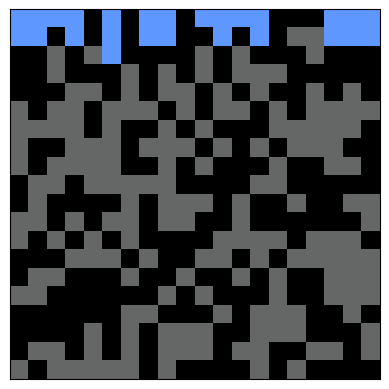

In [31]:
# Testing the PercolationSimulation class
model = PercolationSimulation(n=20, random_state=0, p=0.5)
does_percolate = model.percolate()

# Output the result
print("Does it percolate?", does_percolate)
plot_percolation(model.grid_filled)


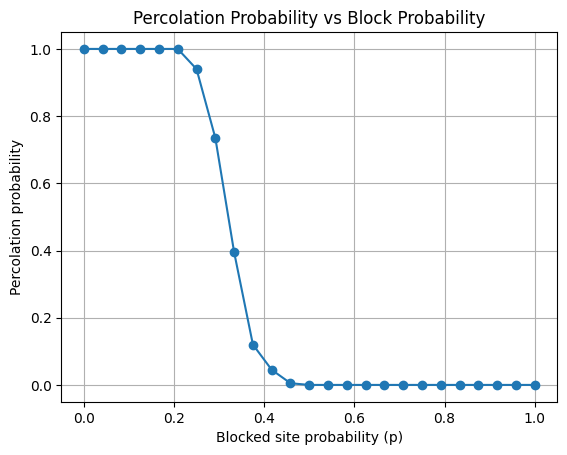

In [50]:
# Performing replicate simulations and plotting percolation probability
pvals = np.linspace(0, 1, 25)  # control parameter for percolation phase transition
n_reps = 200  # number of simulations per p value
grid_size = 30

all_percolations = list()
for p in pvals:
    all_replicates = list()
    for _ in range(n_reps):
        model = PercolationSimulation(grid_size, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

# Plot the results
avg_percolations = np.mean(all_percolations, axis=1)
plt.figure()
plt.plot(pvals, avg_percolations, '-o')
plt.xlabel('Blocked site probability (p)')
plt.ylabel('Percolation probability')
plt.title('Percolation Probability vs Block Probability')
plt.grid(True)
plt.show()


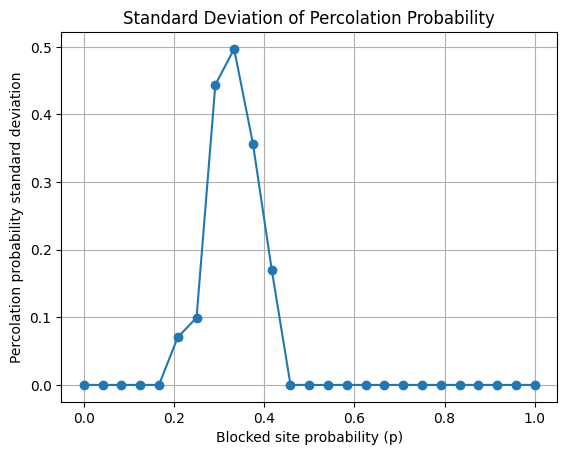

In [49]:
# Plotting standard deviation of the percolation probability
std_percolations = np.std(all_percolations, axis=1)
plt.figure()
plt.plot(pvals, std_percolations, '-o')
plt.xlabel('Blocked site probability (p)')
plt.ylabel('Percolation probability standard deviation')
plt.title('Standard Deviation of Percolation Probability')
plt.grid(True)
plt.show()


In [ ]:
# Analysis
'''What's going on with the variance? 
The standard deviation in the outcome increases as it approaches the critical probability 
(the point where the system transitions from mostly percolating to mostly blocked). Near 
this point, small changes in the grid structure can cause big differences in whether the 
water reaches the bottom, leading to greater variance.

Does the empirical transition align with your intuition? 
From the plots, I noticed a sharp drop in percolation probability around p ≈ 0.41. This 
value is close to the theoretical critical probability for percolation in a 2D grid.

Why does the empirical value differ from the theoretical one? 
The difference between the empirical and theoretical values arises because we are working 
with finite-sized grids in the simulation, while the theoretical critical probability 
assumes an infinite lattice. Finite systems exhibit fluctuations that shift the observed 
critical point.

How does the model scale with lattice size?
The memory scales with the number of sites in the lattice. In the current iterative 
implementation, the runtime scales approximately as O(n^2), since the algorithm 
checks each site in the grid and may need to revisit sites based on neighboring 
conditions.

How do different events in this gradual unblocking relate to timescales seen in sandpile 
problems?
In percolation, the lattice opens gradually as more sites become unblocked. Initially, 
water can't reach the bottom, but as more sites open, critical paths form, allowing 
percolation to occur. This resembles the slow buildup of stress in sandpile problems, 
where a sudden avalanche happens once a critical state is reached. The two timescales 
are the opening of sites and the sudden percolation even when a critical number of 
open sites is reached.

'''